In [42]:
import numpy as np
import rqcopt as oc
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# setup for problem
# get the setup for the problem
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, super2choi
from opentn.optimization import compose_superops_list, frobenius_norm
d, N, gamma = 2, 4, 1
tau = 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma)
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

# 2 site superoperator ansatz
from opentn.transformations import lindbladian2super, create_supertensored_from_local
superop_nn = lindbladian2super(Li=[Lnn])
exp_nn_odd = exp_operator_dt(superop_nn, tau=tau/2, backend='jax')
exp_nn_even = exp_operator_dt(superop_nn, tau=tau, backend='jax')

print(np.linalg.matrix_rank(super2choi(exp_Lvec)))
print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

55
0.0959176702323516


In [88]:
# how would we vectorize the identity?
from opentn.transformations import vectorize_dissipative, vectorize_hamiltonian, dissipative2liouvillian_full
Inn = np.eye(d**2)
print(np.allclose(vectorize_dissipative(Inn), np.zeros((d**4,d**4))), np.allclose(vectorize_hamiltonian(Inn), np.zeros((d**4,d**4))))
# as wrote out on paper, the identity "vectorized" is just zero
print(dissipative2liouvillian_full(L=Lnn, i=1, N=N, num_sites=2).shape)

True True
(256, 256)


In [89]:
from opentn.transformations import convert_supertensored2liouvillianfull
# corresponds to site order: (N-1, 0), (1, 2)
even_full_test = create_supertensored_from_local(exp_nn_even, N=N, pbc=False, layer=1)
swaped_test = convert_supertensored2liouvillianfull(even_full_test, N, d, shift_pbc=True)
np.allclose(swaped_test, exp_Lvec_even)

True

In [90]:
# now another question I have is even the components I am using would make isometries. CHECK
from opentn.transformations import factorize_psd_truncated, choi2ortho
from opentn.stiefel import is_isometry_2
print(is_isometry_2(choi2ortho(factorize_psd_truncated(super2choi(exp_nn_even.real), chi_max=2))))
print(is_isometry_2(choi2ortho(factorize_psd_truncated(super2choi(np.eye(d**4,d**4)), chi_max=d**4))))

test_odd = create_supertensored_from_local(exp_nn_odd, N)
test_odd = convert_supertensored2liouvillianfull(test_odd, N, d)
print(np.allclose(test_odd@swaped_test@test_odd, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd)) # AMAZING
print(frobenius_norm(test_odd@swaped_test@test_odd, exp_Lvec))

True
True
True
0.09591767023235137


# Next steps:
(18 OCT 2023)

1. I want the above functions to be a comprehensible framework. What does this mean?
    a. Their should be one "factory" that takes superop_local -> super_full_liouvillian that takes as argument the parity and shifts (PBC) for the even layer.
    b. I need to try this out fully when also changing the exp(L_full) to include the PBC for the term [N-1,0].
    c. Include a special case for the non PBC such that this old comparison still works
    c. Add even layer to unit tests 
2. Try optimization with the PBC case for St(N)
3. EXTRA: finish creation of identity maps!

In [92]:
# trying out again things but with pbc=True!
from opentn.transformations import create_trotter_layers

d, N, gamma = 2, 4, 1
tau = 4

Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers(liouvillians=[Lvec, Lvec_odd, Lvec_even], tau=tau)

print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

superop_nn = lindbladian2super(Li=[Lnn])

exp_nn_odd = exp_operator_dt(superop_nn, tau=tau/2, backend='jax')
exp_nn_even = exp_operator_dt(superop_nn, tau=tau, backend='jax')

test_even_pbc = create_supertensored_from_local(exp_nn_even, N, pbc=True, layer=1)
test_even_pbc = convert_supertensored2liouvillianfull(test_even_pbc, N, d, shift_pbc=True)

test_odd = create_supertensored_from_local(exp_nn_odd, N)
test_odd = convert_supertensored2liouvillianfull(test_odd, N, d)

0.14312675894435653


In [94]:
# these is supposed to fail 
print(np.allclose(create_supertensored_from_local(exp_nn_even, N, layer=1), create_supertensored_from_local(exp_nn_even, N, pbc=True, layer=1)))
# these are supposed to pass
print(np.allclose(test_odd@test_even_pbc@test_odd, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd)) # AMAZING
print(np.allclose(Lvec, Lvec_odd+Lvec_even))

np.linalg.matrix_rank(super2choi(exp_Lvec)), 4**3, 2**4 # NOTE: the 2 comes from the fact that 2 kraus operators come out from the liouvillian acting on 2 sites.

False
True
True


(45, 64, 16)

In [84]:
# I want to create a utility function that converts the superoperator to orthogonal directly
from opentn.transformations import super2ortho
from opentn.stiefel import check_isometries
from opentn.optimization import model_stiefel_local
xs_pbc_stiefel = [super2ortho(x.real) for x in [exp_nn_odd, exp_nn_even, exp_nn_odd]]
print(check_isometries(xs_pbc_stiefel), [op.shape for op in xs_pbc_stiefel])
print(frobenius_norm(model_stiefel_local(xs_pbc_stiefel, N=N, d=d), exp_Lvec))

[True, True, True] [(8, 4), (8, 4), (8, 4)]
0.14312675894435722


In [15]:
# now it is time to define the elements for the optimization!
from opentn.stiefel import retract_stiefel, gradient_stiefel_vec, riemannian_hessian_vec
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N=N, d=d), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel)
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel)

In [19]:
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
xs_pbc_1, f_pbc_1, err_pbc_1, radius_pbc_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
radius 0.000625
iteration: 5
column : 0
column : 1
column : 2
radius 0.000625
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.0025
iteration: 8
column : 0
column : 1
column : 2
radius 0.005
iteration: 9
column : 0
column : 1
column : 2
radius 0.00125
iteration: 10
column : 0
column : 1
column : 2
radius 0.00125
iteration: 11
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 12
column : 0
column : 1
column : 2
radius 0.000625
iteration: 13
column : 0
column : 1
column : 2
radius 0.000625
iteration: 14
column : 0
column : 1
column : 2
radius 0.000625
iteration: 15
column : 0
column : 1
column : 2
radius 0.000625
iteration: 16
colum

In [20]:
xs_pbc_2, f_pbc_2, err_pbc_2, radius_pbc_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_pbc_1, niter=20, radius_init=radius_pbc_1
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 1
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 2
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 3
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 4
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 5
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 6
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 7
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 8
column : 0
column : 1
column : 2
radius 0.000625
iteration: 9
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 10
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 11
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 12
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 13
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 14
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 15
column : 0
column :

0.8853557271233199 [True, True, True]


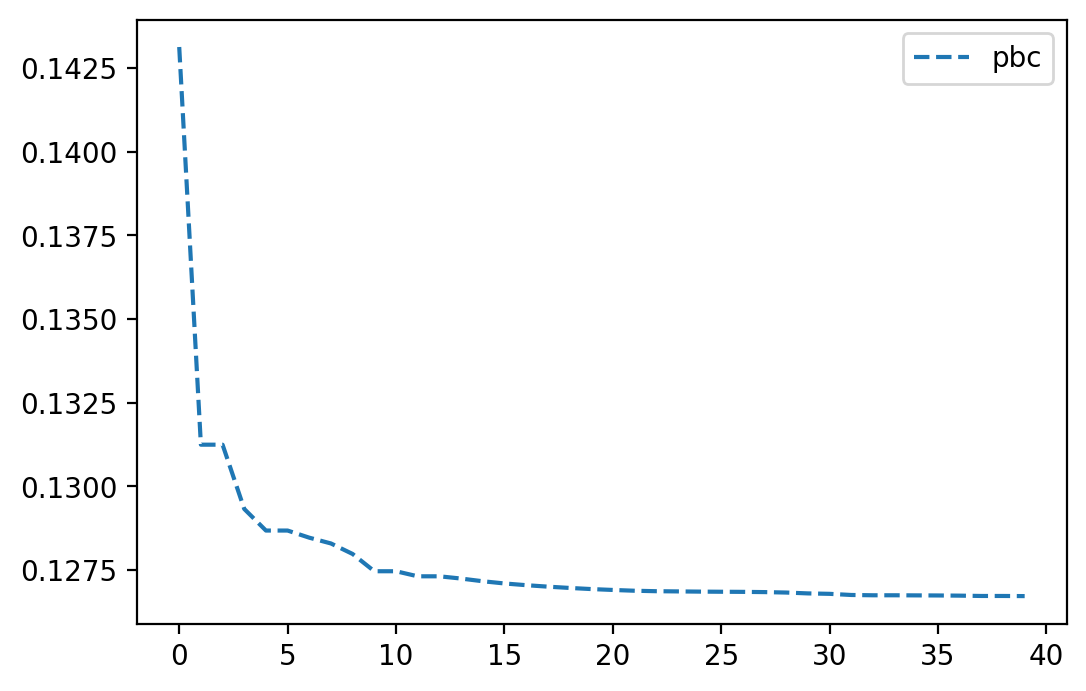

In [95]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(f_pbc_1 + f_pbc_2, '--', label='pbc')
plt.legend()
print(f_pbc_2[-1]/f_pbc_1[0], check_isometries(xs_pbc_2))

In [71]:
# just to be sure that everything is right: TODO: I need to check that the error of this model decreases with tau**3
taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
error_fro = []
for tau in taus:
    exp_tot_tau = exp_operator_dt(Lvec, tau=tau, backend='jax')
    exp_odd_tau = exp_operator_dt(Lvec_odd, tau=tau/2, backend='jax')
    exp_even_tau = exp_operator_dt(Lvec_even, tau=tau, backend='jax')
    error_fro.append(frobenius_norm(exp_odd_tau@exp_even_tau@exp_odd_tau,exp_tot_tau))

[1.953125e-03 3.906250e-03 7.812500e-03 1.562500e-02 3.125000e-02
 6.250000e-02 1.250000e-01 2.500000e-01 5.000000e-01 1.000000e+00
 2.000000e+00 4.000000e+00]


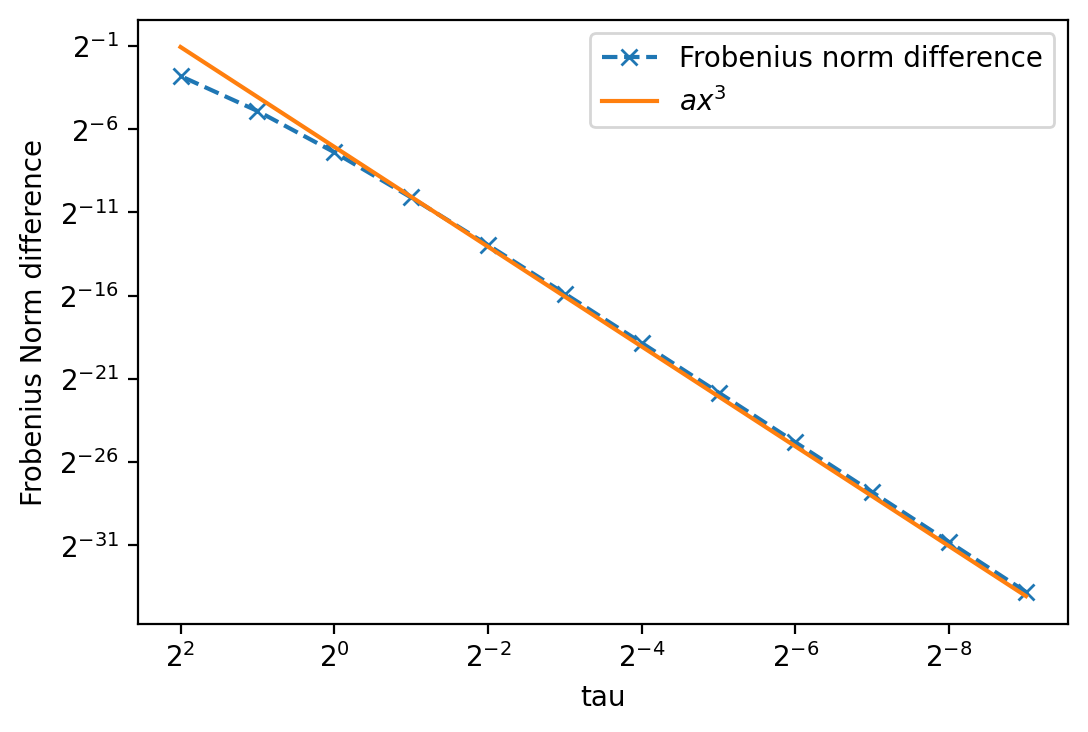

In [72]:
a = 0.0075
fig = plt.figure(dpi=200)
plt.loglog(taus, error_fro, '--x', base=2, label='Frobenius norm difference')
plt.plot(taus, a*taus**3, label=r'$a x^3$')
plt.gca().invert_xaxis()
plt.ylabel(r'Frobenius Norm difference')
plt.xlabel('tau')
plt.legend()
print(taus)

In [97]:
# after checking that this works as it is supposed to (based on error behaviour and unittests)
# so the next thing is to try canonical metric!
# 1. Start with the gradients
from opentn.stiefel import gradient_metric, gradient_stiefel, gradient_canonical
gradients_ambient = jax.grad(f_stiefel)(xs_pbc_stiefel)
gradients_euclidean = [gradient_metric(x,z) for x,z in zip(xs_pbc_stiefel, gradients_ambient)]
print([np.allclose(g1, g2) for g1, g2 in zip(gradients_euclidean,  gradient_stiefel(xs_pbc_stiefel, f_stiefel))])

gradients_canonical = [gradient_metric(x,z, 1, 1/2) for x,z in zip(xs_pbc_stiefel, gradients_ambient)]
print([np.allclose(g1, g2) for g1, g2 in zip(gradients_canonical, gradient_canonical(xs_pbc_stiefel, f_stiefel))])

[True, True, True]
[True, True, True]


In [172]:
# now, there seems to be an issue with the riemannian connection.
from opentn.stiefel import project, get_unit_matrices, is_in_tangent_space
# let me calculate D_eta(nu):
grad_func = lambda xi: gradient_stiefel(xi, f_stiefel)
x = xs_pbc_stiefel
unit_matrices = get_unit_matrices(x)
k = 1
grads = grad_func(x)
_, jvp_eval = jax.jvp(grad_func, (x,), ([jnp.zeros_like(op, dtype=np.float64) if l!=i else project(X=op, Z=jnp.roll(unit_matrices[l],k)) for l,op in enumerate(x)],))
[np.allclose(op, np.zeros_like(op)) for op in jvp_eval]

[False, False, False]

In [173]:
[is_in_tangent_space(x, grad) for x,grad in zip(x, jvp_eval)]

[True, True, True]

In [174]:
[np.allclose(project(x, grad), grad) for x,grad in zip(x, jvp_eval)]

[True, True, True]

In [185]:
from opentn.stiefel import riemannian_connection
hessian_metric = riemannian_connection(D_nu=jvp_eval[k], nu=grads[k], eta=project(X=x[k], Z=unit_matrices[k]), x=x[k], alpha0=1, alpha1=1/2)
print(np.allclose(hessian_metric, np.zeros_like(hessian_metric)))
print(np.allclose(hessian_metric, jvp_eval[k]))
print(np.allclose(project(x[k], jvp_eval[k]), jvp_eval[k]))

False
True
True


In [182]:
nu=grads[k]
# eta=project(X=x[k], Z=unit_matrices[k])
eta = project(x[k], unit_matrices[k])         
print(np.allclose((eta.T @ nu + nu.T @ eta), np.zeros_like(eta.T @ nu + nu.T @ eta)))
print(np.allclose((eta @ nu.T + nu @ eta.T), np.zeros_like(eta @ nu.T + nu @ eta.T)))

# This sort of gives me the idea that the hessian would not change. What could be wrong is me assuming that I should
# project the Ei and that is why the whole thing is in the tangent space by default.

True
True


In [177]:
# lets try to quickly run an optimization with the canonical gradient instead
grad_stiefel_canon = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')

xs_pbc_canon_1, f_pbc_canon_1, err_pbc_canon_1, radius_pbc_canon_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
radius 0.005
iteration: 4
column : 0
column : 1
column : 2
radius 0.00125
iteration: 5
column : 0
column : 1
column : 2
radius 0.00125
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.00125
iteration: 8
column : 0
column : 1
column : 2
radius 0.00125
iteration: 9
column : 0
column : 1
column : 2
radius 0.00125
iteration: 10
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 11
column : 0
column : 1
column : 2
radius 0.000625
iteration: 12
column : 0
column : 1
column : 2
radius 0.000625
iteration: 13
column : 0
column : 1
column : 2
radius 0.000625
iteration: 14
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 15
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 16


In [180]:
xs_pbc_canon_2, f_pbc_canon_2, err_pbc_canon_2, radius_pbc_canon_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel, xs_pbc_canon_1, niter=20, radius_init=radius_pbc_2
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 1
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 2
column : 0
column : 1
column : 2
radius 0.000625
iteration: 3
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 4
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 5
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 6
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 7
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 8
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 9
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 10
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 11
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 12
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 13
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 14
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 15
column : 0
column : 1
c

In [232]:
grad_stiefel_euclidean = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='euclidean')
hessian_stiefel_euclidean = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='euclidean')


xs_pbc_euclidean_1, f_pbc_euclidean_1, err_pbc_euclidean_1, radius_pbc_euclidean_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_euclidean, hessian_stiefel_euclidean, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
radius 0.000625
iteration: 5
column : 0
column : 1
column : 2
radius 0.00125
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.00125
iteration: 8
column : 0
column : 1
column : 2
radius 0.00125
iteration: 9
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 10
column : 0
column : 1
column : 2
radius 0.000625
iteration: 11
column : 0
column : 1
column : 2
radius 0.000625
iteration: 12
column : 0
column : 1
column : 2
radius 0.000625
iteration: 13
column : 0
column : 1
column : 2
radius 0.000625
iteration: 14
column : 0
column : 1
column : 2
radius 0.000625
iteration: 15
column : 0
column : 1
column : 2
radius 0.000625
iteration: 16
c

In [213]:
hessian_stiefel_canon = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')
xs_pbc_canon_upd_1, f_pbc_canon_upd_1, err_pbc_canon_upd_1, radius_pbc_canon_upd_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel_canon, xs_pbc_stiefel, niter=10
)
# NOTE: attempt without the projection did not work

iteration: 0
column : 0
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
tangent
column : 1
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tangent
tangent
tangent
not tange

In [195]:
check_isometries(xs_pbc_canon_upd_1)

[True, True, True]

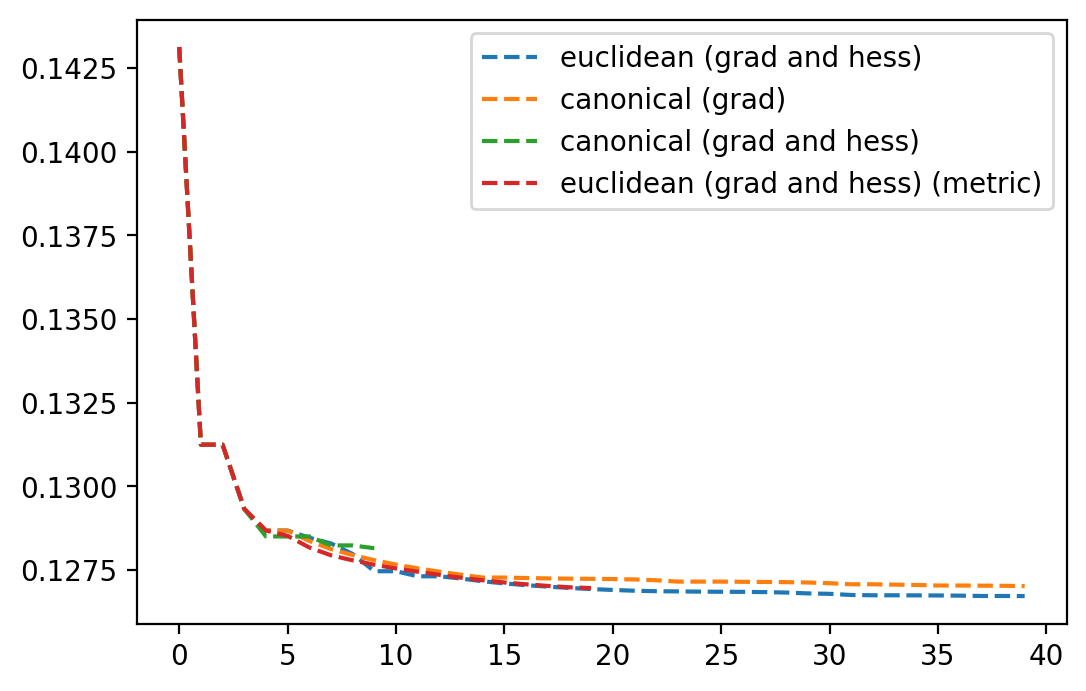

In [233]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(f_pbc_1 + f_pbc_2, '--', label='euclidean (grad and hess)')
plt.plot(f_pbc_canon_1 + f_pbc_canon_2, '--', label='canonical (grad)')
plt.plot(f_pbc_canon_upd_1, '--', label='canonical (grad and hess)')
plt.plot(f_pbc_euclidean_1, '--', label='euclidean (grad and hess) (metric)')
plt.legend()

In [231]:
print(f_pbc_canon_upd_1)
print(f_pbc_euclidean_1)

[DeviceArray(0.14312676, dtype=float64), DeviceArray(0.13124284, dtype=float64), DeviceArray(0.13124284, dtype=float64), DeviceArray(0.12932256, dtype=float64), DeviceArray(0.12850057, dtype=float64), DeviceArray(0.12850057, dtype=float64), DeviceArray(0.12850057, dtype=float64), DeviceArray(0.12823277, dtype=float64), DeviceArray(0.12823277, dtype=float64), DeviceArray(0.12814822, dtype=float64)]
[DeviceArray(0.14312676, dtype=float64), DeviceArray(0.13124284, dtype=float64), DeviceArray(0.13124284, dtype=float64), DeviceArray(0.12932256, dtype=float64), DeviceArray(0.12867716, dtype=float64), DeviceArray(0.12851875, dtype=float64), DeviceArray(0.12817087, dtype=float64), DeviceArray(0.12793762, dtype=float64), DeviceArray(0.127787, dtype=float64), DeviceArray(0.12765615, dtype=float64), DeviceArray(0.12754447, dtype=float64), DeviceArray(0.12744621, dtype=float64), DeviceArray(0.12735373, dtype=float64), DeviceArray(0.12726769, dtype=float64), DeviceArray(0.1271914, dtype=float64), D

In [210]:
np.roll(get_unit_matrices(xs_pbc_stiefel)[0], shift=xs_pbc_stiefel[0].size-1)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])